# <center>Дипломная работа</center>

## <center>"Построение и оптимизация модели Машинного Обучения для прибыльной торговли финансовыми инструментами на биржах"</center>

### Содержание:  
1. Описание бизнес-задачи.
2. Постановка задачи и подготовка данных.
3. Загрузка данных, их предобработка и обогащение признаками.
4. Проведённый эксперимент.  
4.1. Эксперимент - применение разных методов и выбор метода.  
4.2. Построение модели с оптимизацией гиперпараметров.  
5. Результаты и выводы.

### 1. Описание бизнес-задачи.

#### Современные биржи выполняют различные функции:  
* Рыночное определение стоимости компаний, курсов валют, стоимости сырья и т.д.
* Привлечение компаниями инвестиций для своего дальнейшего развития.
* Получение дохода от спекулятивной торговли.

### <u>Бизнес-задача:</u>
Построить модель трейдинга, которая будет приносить доход не менее межбанковской ставки Центрального Банка России.

### 2. Постановка задачи и подготовка данных.

#### В трейдинге критичным для успеха в торговле и самым сложным являются:  
* выбор момента входа в сделку (покупка при игре на повышение или продажа актива при ставке на понижение),
* выбор момент выхода из сделки (фиксация прибыли или незначительного убытка при выставлении stop loss).

**Прибыльность или убыточность торговой стратегии определяется формулой:**  
Вероятность прибыльной сделки * Размер прибыли - Вероятность убыточной сделки * Размер убытка  

Поэтому важно, чтобы:  
* в момент входа в сделку вероятность прибыльности сделки была выше вероятности убыточной сделки
* размер прибыли от каждой сделки был, по крайней мере, не ниже размера убытка.

### Постановка задачи:  
* При помощи методов машинного обучения построить модели, когда вероятность прибыли при входе в сделку будет выше чем вероятность убытка.
* Для упрощения задачи расстояния между входом в сделку и выходом из неё (размер прибыли или убытка) считаем одинаковыми, что позволит определять только вероятности роста инструментов финансового рынка вверх или падения вниз.

### Предлагаемый подходы к решению задачи:  
* Сведём задачу к задаче бинарной классификации.

* Возможно рассмотрение бизнес-задачи как прогнозирование поведения временных рядов, но есть дополнительные вопросы в связи:
  - неопределённостью по времени закрытия сделки (когда закрывать),
  - накопления ошибки прогноза по мере удаления от начальной точки,
  - задача классификации проще в реализации.

* Число успешных сделок будет рассчитываться по фактам преодоления расстояния от цены покупки или продажи акции (цена закрытия торгового часа) до достижения определённого расстояния(+/- X% от цены покупки или продажи), рассчитанного заранее по истории цены, на каждом часе валидационного периода. Пробным расстоянием считаем 5% на первом этапе анализа. Далее это значение можем менять для рассмотрения различных сценариев.

### 3. Загрузка данных, их предобработка и обогащение признаками.

##### Загружаем необходимые библиотеки и созданные классы по созданию новых признаков, конвейера обработки и оценки точности моделей.

In [11]:
import time
start_time = time.time()
import pandas as pd
import numpy as np
import requests

from datetime import datetime
from tqdm import tqdm
import talib

import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from pandas.plotting import scatter_matrix
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#### Загружаем созданные библиотеки с классами и методами, которые позволят структурировать общий код: 
* StockAnalyzer с классами и методами обогащения модели признаками
* StockProcessing с классами и методами загрузки данных через API Московской Биржи и предобработки данных
* Accuracy_Analyzer с классами и методами оценки точности и некоторых других функций

In [14]:
from trade.Stock_Analyzer import *
from trade.StockProcessing import *
from trade.Accuracy_Analyzer import *
from trade.CustomPipeline import *

In [15]:
# Загружаем исторические данные с интервалом 60 минут
if __name__ == "__main__":
    ticker = 'SBER'
    interval = 60
    
    # Задаем корректные даты
    start_date = '1990-01-01 10:00:00'  # начальной даты
    end_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    downloader = StockDataDownloader(ticker, interval)
    stock_data = downloader.fetch_data(start_date, end_date)
    
    if not stock_data.empty:
        downloader.save_to_excel(stock_data, f'{ticker}_{interval}m_data.xlsx')
        print(f"Исторические данные по инструменту {ticker} загружены")

Исторические данные по инструменту SBER загружены


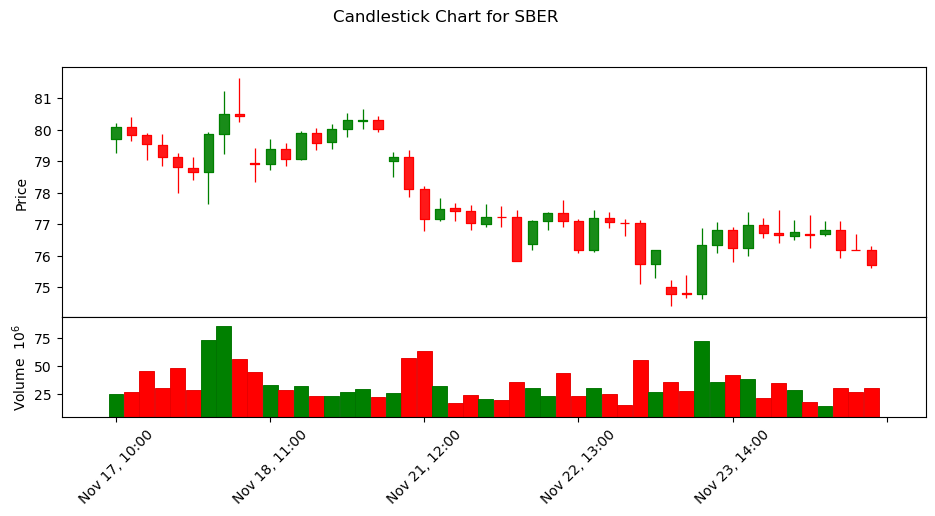

In [16]:
df_ = pd.read_excel(f'{ticker}_{interval}m_data.xlsx')

# Как выглядит свечной график для трейдеров 
mc = mpf.make_marketcolors(up='green', down='red', inherit=True)
s = mpf.make_mpf_style(marketcolors=mc)

mpf.plot(df_.set_index('begin')[:50], type='candle', volume=True, 
         title=f'Candlestick Chart for {ticker}', style = s, figsize = (12,5))

In [17]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37879 entries, 0 to 37878
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   open    37879 non-null  float64       
 1   close   37879 non-null  float64       
 2   high    37879 non-null  float64       
 3   low     37879 non-null  float64       
 4   volume  37879 non-null  int64         
 5   begin   37879 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.7 MB


#### Данные включают:  
* open - стоимость инструмента в начале часа
* close - стоимость по окончанию часа
* high - максимальную цену в течение часа
* low - минимальную цену в течение часа
* volume - общее кол-во проданных и купленных штук
* begin - время начала часа

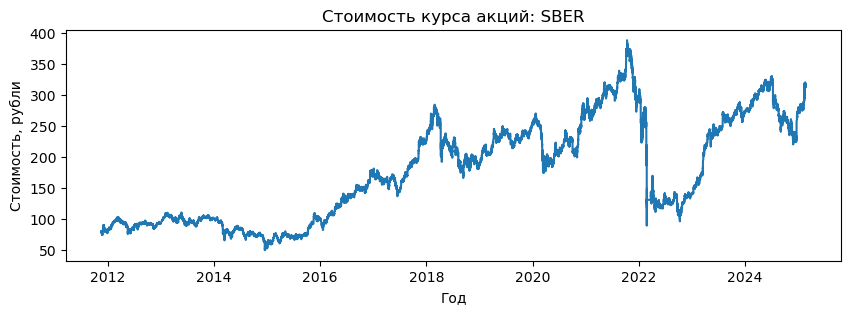

In [19]:
# График поведения акций по значениям close
plt.figure(figsize=(10, 3))
plt.title(f'Стоимость курса акций: {ticker}')
plt.xlabel('Год')
plt.ylabel('Стоимость, рубли')
plt.plot(df_.begin, df_.close)
plt.show()

##### Создаём колонку с 1 (рост на delta_ex % от текущих значений по каждому часу), 0 (снижение на delta %) и -1 (акция не успела достичь границ). Кроме того, создаётся колонка n_close, которая содержит индексы строк, на которых произошло достижение границ максимумом или минимумом финансового инструмента.

In [21]:
delta_ex = 0.05 # выбранный диапазон в 5%

analyzer = PriceMovementAnalyzer(delta_ex)
df = analyzer.growth_drop(df_)

df.info()

100%|██████████| 37879/37879 [00:52<00:00, 719.07it/s] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37879 entries, 0 to 37878
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   open     37879 non-null  float64       
 1   close    37879 non-null  float64       
 2   high     37879 non-null  float64       
 3   low      37879 non-null  float64       
 4   volume   37879 non-null  int64         
 5   begin    37879 non-null  datetime64[ns]
 6   result   37879 non-null  int64         
 7   n_close  37754 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 2.3 MB


In [22]:
# проверка количества значений в колонке result:
df['result'].value_counts()

result
 1    21603
 0    16151
-1      125
Name: count, dtype: int64

### Выводы:  
* Часть записей остались неразмеченными со значениями -1, что логично, поскольку в конце истории стоимость инструмента могла не успеть достичь рассчитанных уровней  
* Если рассматривать значения 1 и 0 как классы, то для задачи классификации они оказались незначительно несбалансированными, для балансировки можем применить дополнительные методы

#### Чтобы убрать -1, просто разделим датафрейм на 2 датафрейма: 
- Основной будет включать только записи до момента, когда появилось первое значение -1 и на нём будем проводить **обучение и тестирование**.
- второй, в котором могут быть как значения -1, так и 1 и 0. Этот датафрейм оставим до накопления данных и для дополнительного сравнения эффективности методов классификации.

In [24]:
if not df[df['result']== -1].empty:
    df_use = df[0:df[df['result']== -1].index[0]] # строки со значениями 1 и 0
    df_future_use = df[df[df['result']== -1].index[0]:] # последовательные строки которые могут содержать -1

In [25]:
# проверка количества значений в колонке result:
df_use['result'].value_counts()

result
1    21602
0    16151
Name: count, dtype: int64

In [26]:
# проверка количества значений в отложенном на будущее датафрейме:
df_future_use['result'].value_counts()

result
-1    125
 1      1
Name: count, dtype: int64

##### Применяем метод, который рассчитывает кол-во часов до достижения границ. Значения размещены d колонке diff_hours.

In [28]:
calculator = TimeDifferenceCalculator(df_use)
updated_df_ = calculator.apply_to_dataframe()

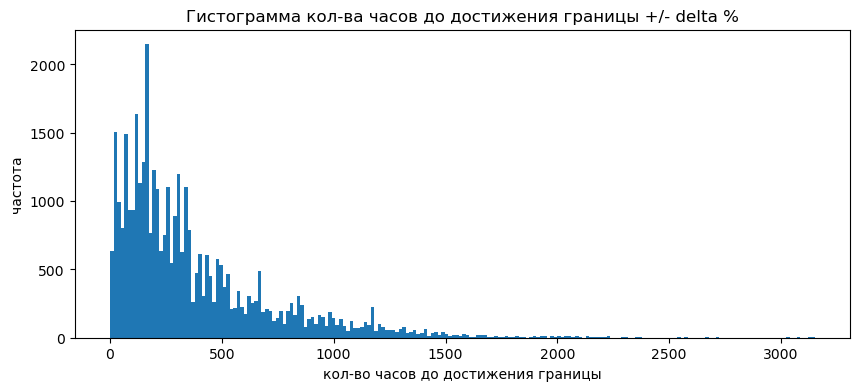

In [29]:
plt.figure(figsize = (10, 4))
plt.hist(x = updated_df_['diff_hours'], bins = 200)
plt.xlabel('кол-во часов до достижения границы')
plt.ylabel('частота')
plt.title('Гистограмма кол-ва часов до достижения границы +/- delta %')
plt.show()

In [30]:
updated_df_['diff_hours'].describe()

count    37753.000000
mean       377.575663
std        354.961791
min          0.000000
25%        138.000000
50%        265.000000
75%        503.000000
max       3150.000000
Name: diff_hours, dtype: float64

##### Медиана = 265 часов, средняя величина достижения границ примерно 378 часов. Это будем использовать для расчёта ожидаемой доходности.  
Пример: Доходность 0.5% прибыль каждые 265 часов означает 365 x 24/265 x 0.5% = 16.5% годовых

##### Потребуются 2 пайплайна для обработки данных и добавления признаков:  
* Для обучения модели и выбора гиперпараметров, также как универсального для разделения датасета на тренировочного и тестируемого
* Для предобработки тестируемого датасета без удаления коррелирующих с целевыми значениями или сильно коррелируемых между собой

In [33]:
pipeline_transform = Pipeline(steps=[
    ('RSI', RSIAnalyzer()),  # добавляем признаки из классического RSI индикатора, основанного на SMA
    ('SMA', SMAAnalyzer()),  # +SMA (simple moving average) для 3-х периодов
    ('EMA', EMAAnalyzer()),  # +EMA (exponential moving average) для 3-х периодов
    ('RSIEMA', RSIEMAAnalyzer()), # + признаки из RSI индикатора, основанного на EMA
    ('ROC', ROCAnalyzer()), # + признаки из ROC индикатора
    ('MOM', MomentumAnalyzer()), # + признаки из MOM индикатора
    ('STOCH', StochasticOscillatorAnalyzer()), #  + признаки из Stochastic Oscillator
    ('SHIFT1', ShiftedColumnAdder(columns_to_shift=['open', 'close', 'high', 'low', 'volume'])), # + сдвиг значений, по умолчанию 3
    ('SHIFT2', ShiftedColumnAdder(num_shifts=1, columns_to_shift=['EMA_short', 'EMA_long', 'EMA_longest'])), # + сдвиг значений
    ('TIME_CONVERTER', DateTimeConverter()), # + признаки связанные с временем: день недели, номер месяца ...
    ('DEPENDENCIES_REMOVER', DependentFeatureRemover()),  # + удаление признаков коррелирующих между собой, по умолчанию коэффициент 0.9
    ('CORRELATION_REMOVER', LowCorrelationRemover(target_column='result')), # + удаление признаков слабо коррелирующих с целевыми значениями
    ('DATAPREPROCESSOR', DataPreprocessor(target_column='result', # указана колонка с целевыми значениями - будет на выходе датафрйм и серия с целями
                                          apply_scaling=True,
                                          apply_balancing=True)) #чтобы не перемешивать последовательности до разделения на обучающую и тестовую последовательности
])

In [34]:
pipeline_transform_test = Pipeline(steps=[
    ('RSI', RSIAnalyzer()),  
    ('SMA', SMAAnalyzer()),
    ('EMA', EMAAnalyzer()),
    ('RSIEMA', RSIEMAAnalyzer()),
    ('ROC', ROCAnalyzer()),
    ('MOM', MomentumAnalyzer()),
    ('STOCH', StochasticOscillatorAnalyzer()),
    ('SHIFT1', ShiftedColumnAdder(columns_to_shift=['open', 'close', 'high', 'low', 'volume'])),
    ('SHIFT2', ShiftedColumnAdder(num_shifts=1, columns_to_shift=['EMA_short', 'EMA_long', 'EMA_longest'])),
    ('TIME_CONVERTER', DateTimeConverter()),
    #('DEPENDENCIES_REMOVER', DependentFeatureRemover()),  
    #('CORRELATION_REMOVER', LowCorrelationRemover(target_column='result)),
    ('DATAPREPROCESSOR', DataPreprocessor(target_column='result', # указана колонка с целевыми значениями - будет на выходе датафрйм и серия с целями
                                          apply_scaling=True,
                                          apply_balancing=False)) #чтобы не перемешивать последовательности до разделения на обучающую и тестовую последовательности
])

In [35]:
df_use.drop(['n_close', 'diff_hours'], axis = 1, inplace = True) # теперь эти 2 колонки не понадобятся

In [36]:
df_full = df_use.copy()
test_size = 0.2
train_size = int(len(df_full) * (1 - test_size))

In [37]:
X_train = df_full.iloc[:train_size]
X_train, y_train = pipeline_transform.fit_transform(X_train) # на выходе получаем отдельно тренировочные датасеты

In [38]:
X, y = pipeline_transform_test.fit_transform(df_full) # для сохранения признаков на переходе от тренировочного к тестовому датасетах

In [39]:
X_test= X.iloc[train_size:]
y_test = y.iloc[train_size:]

In [40]:
# оставили только те колонки в тестовом датасете, которые остались в тренировочном после удаления коррелирующих и зависимых признаков
columns_list = X_train.columns.to_list()
X_test = pd.DataFrame(X_test, columns = columns_list) 

In [41]:
# проверка, что набор признаков в тренировочном и тестовом датасете совпадают 
if set(X_train.columns) == set(X_test.columns) and len(X_train.columns) == len(X_test.columns):
    print("Количество и названия колонок совпадают")
else:
    print("Количество колонок или названия колонок не совпадают")

Количество и названия колонок совпадают


##### Посмотрим на корреляционную матрицу по оставшимся признакам в тренировочном датасете

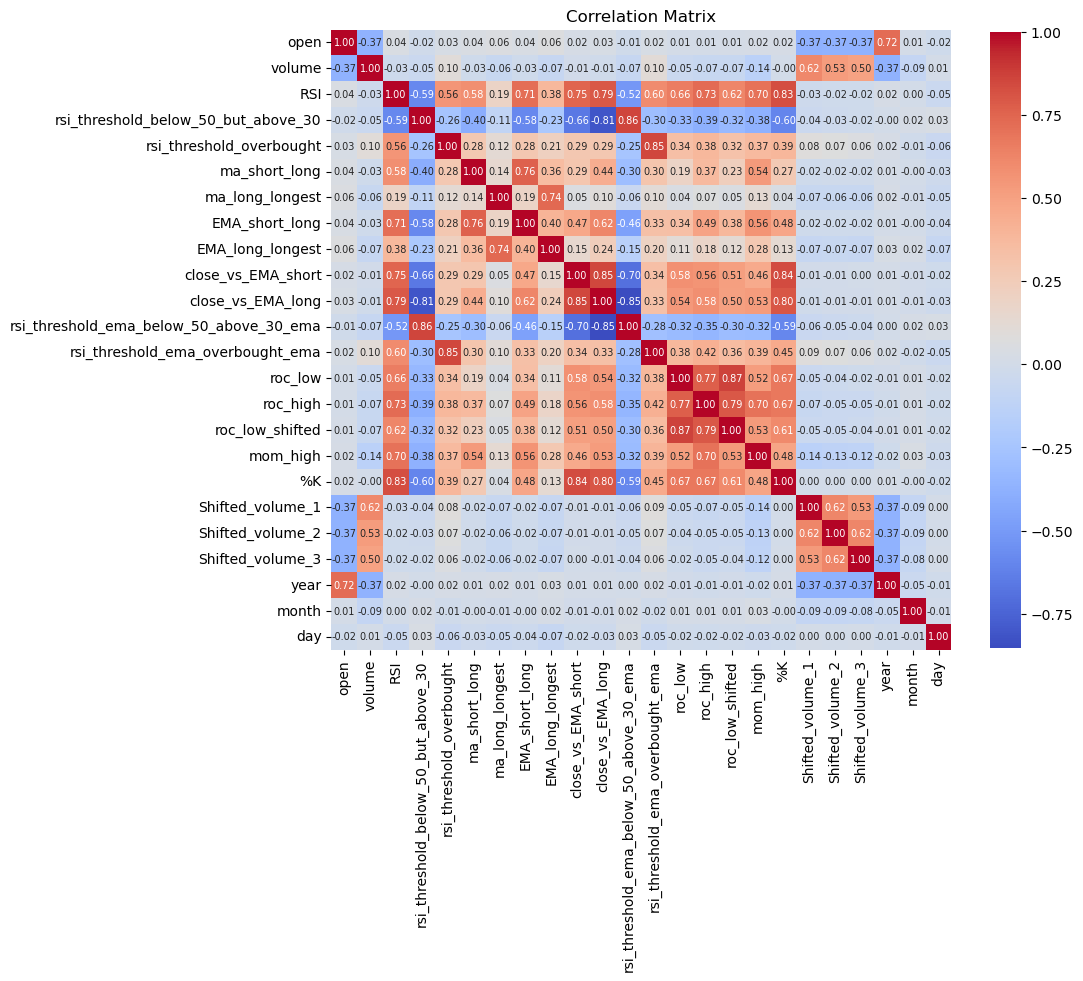

In [43]:
plt.figure(figsize = (10,10))
sns.heatmap(X_train.corr(), annot = True, annot_kws = {'fontsize': 7}, fmt=".2f", cmap='coolwarm', square=True, cbar_kws = {"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

##### Интересные зависимости:  
* Высокая корреляция между годом и ценой открытия, что означает рост акций с годами, что, в целом, логично для развивающегося рынка.
* RSI коррелирует с close_vs_EMA_short, close_vs.EMA_long что означает что при высоком RSI значение закрытия акции выше или ниже соответствующих EMA (RSI высокое -> значение акции выше кривых и наоборот)
* Volume, Shifted_Volumes коррелируют между собой, что говорит о том, что периоды похожих объёмов продаж близки между собой
* и т.д.

### 4.1. Эксперимент - применение разных методов и выбор метода

In [46]:
# тестируем различные методы с параметрами по умолчанию
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
#Simple Neural Network
models.append(('NN', MLPClassifier()))
# Boosting methods
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs = -1)))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('LGB', lgb.LGBMClassifier(force_col_wise=True, verbosity = -1)))

In [47]:
results_accuracy = []
results_roc_auc = []
names = []
num_folds = 10
seed = 42#, shuffle = False, seed = None

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle = True) #shuffle = True
    cv_results_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_results_roc_auc = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')    
    results_accuracy.append(cv_results_accuracy)
    results_roc_auc.append(cv_results_roc_auc)
    names.append(name)
    msg_accuracy = "%s %s%s: %f (%f)" % (name, 'accuracy', "(std)", cv_results_accuracy.mean(), cv_results_accuracy.std())
    msg_roc_auc = "%s %s%s: %f (%f)" % (name, 'roc_auc', "(std)", cv_results_roc_auc.mean(), cv_results_roc_auc.std())    
    print(msg_accuracy,"     ", msg_roc_auc)

LR accuracy(std): 0.577300 (0.008858)       LR roc_auc(std): 0.607881 (0.009323)
LDA accuracy(std): 0.577330 (0.008672)       LDA roc_auc(std): 0.607710 (0.009245)
KNN accuracy(std): 0.864357 (0.005165)       KNN roc_auc(std): 0.937434 (0.004089)
CART accuracy(std): 0.952653 (0.004510)       CART roc_auc(std): 0.952545 (0.003646)
NB accuracy(std): 0.549811 (0.008625)       NB roc_auc(std): 0.573060 (0.010749)
SVC accuracy(std): 0.624828 (0.008791)       SVC roc_auc(std): 0.676504 (0.010606)
NN accuracy(std): 0.735415 (0.013700)       NN roc_auc(std): 0.812611 (0.017736)
XGB accuracy(std): 0.958301 (0.002278)       XGB roc_auc(std): 0.990216 (0.001414)
RF accuracy(std): 0.951000 (0.003556)       RF roc_auc(std): 0.988477 (0.001621)
AB accuracy(std): 0.685123 (0.004531)       AB roc_auc(std): 0.754200 (0.005910)
GBM accuracy(std): 0.799976 (0.009418)       GBM roc_auc(std): 0.874093 (0.005992)
LGB accuracy(std): 0.942649 (0.006079)       LGB roc_auc(std): 0.983537 (0.002417)


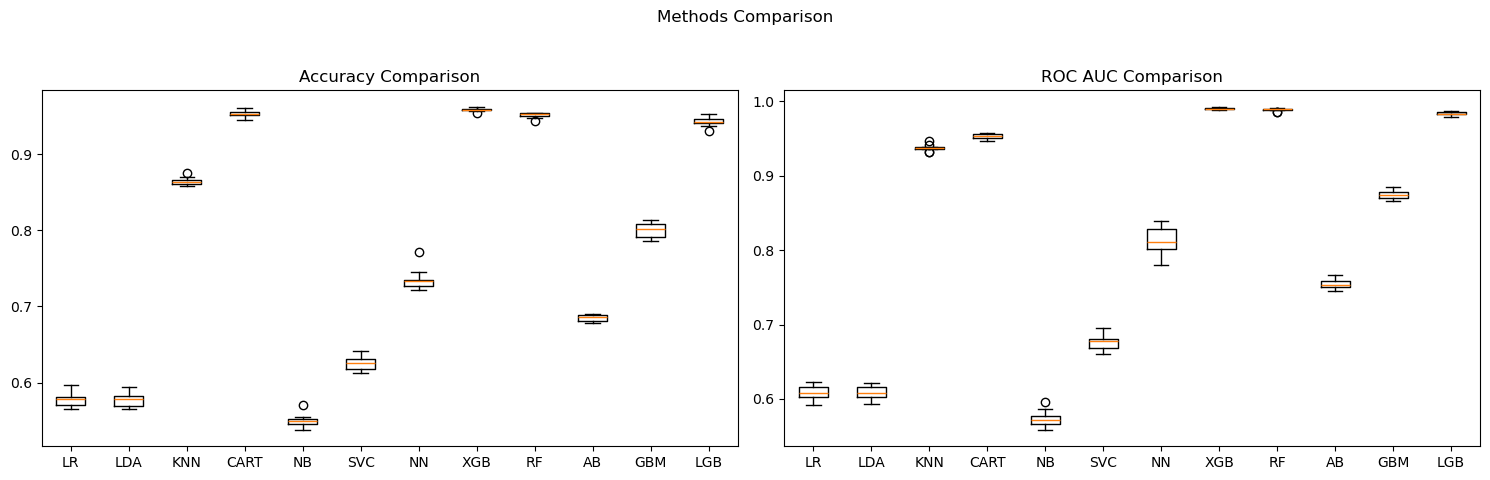

In [48]:
fig = plt.figure(figsize=(15, 5))

# Первый боксплот для точности
ax1 = fig.add_subplot(121)  # 1 строка, 2 колонки, 1-й график
ax1.boxplot(results_accuracy)
ax1.set_title('Accuracy Comparison')
ax1.set_xticklabels(names)

# Второй боксплот для ROC AUC
ax2 = fig.add_subplot(122)  # 1 строка, 2 колонки, 2-й график
ax2.boxplot(results_roc_auc)
ax2.set_title('ROC AUC Comparison')
ax2.set_xticklabels(names)

# Отображение графиков
plt.suptitle('Methods Comparison')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Для корректного размещения заголовка
plt.show()

#### Был выбран метод Random Forest по причинне более простого использования в выборе оптимальных гиперпараметров.

##### Проверка точности модели на параметрах по умолчанию:

In [50]:
X_train = df_full.iloc[:train_size]
X_train, y_train = pipeline_transform.fit_transform(X_train) # на выходе получаем отдельно тренировочные датасеты

In [51]:
# Перемешивание данных
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

In [52]:
# Обучение модели
model = RandomForestClassifier(n_jobs = -1)#  DecisionTreeClassifier() #XGBClassifier() #KNeighborsClassifier() #
model.fit(X_train_shuffled, y_train_shuffled)

# Получение предсказаний на тестовых данных
y_pred = model.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Точность:", accuracy)
print("Отчет по классификации:\n", report)

Точность: 0.5261554760958813
Отчет по классификации:
               precision    recall  f1-score   support

           0       0.31      0.31      0.31      2592
           1       0.64      0.64      0.64      4959

    accuracy                           0.53      7551
   macro avg       0.47      0.47      0.47      7551
weighted avg       0.53      0.53      0.53      7551



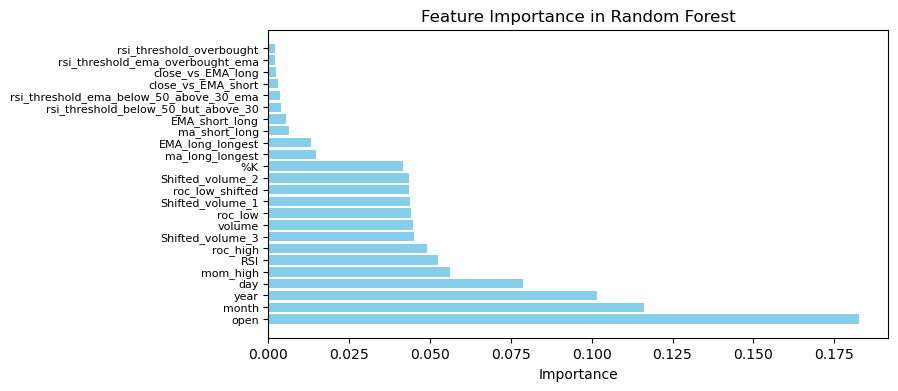

In [53]:
# Получаем важность признаков
importances = model.feature_importances_

# Создаем DataFrame для удобства визуализации
importance_df = pd.DataFrame({'Feature': X_train_shuffled.columns, 'Importance': importances})

# Сортируем по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализируем важность признаков
plt.figure(figsize=(8, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.yticks(fontsize=8)
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()

##### Проверим какие признаки будут наиболее важными при применении RFECV метода отбора признаков, который сочетает Recursive Feature Elimination (RFE) с Cross-Validation (CV) и проверим точность модели при наиболее важных признаках

In [55]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [56]:
X_train = df_full.iloc[:train_size]
X_train, y_train = pipeline_transform_test.fit_transform(X_train)

In [57]:
model = RandomForestClassifier(n_jobs = -1)

In [58]:
# Инициализация RFECV
rfecv = RFECV(
    estimator=model,
    step=1,  # количество удаляемых признаков на каждом шаге
    cv=StratifiedKFold(5, shuffle = True, random_state = 7),
    min_features_to_select=20,
    scoring='accuracy'
)

# Запуск RFECV
rfecv.fit(X_train, y_train)

# Результаты
print("Оптимальное количество признаков:", rfecv.n_features_)


# Получение оставшихся признаков
selected_features = X_train.columns[rfecv.support_]
print("Оставшиеся признаки:")
print(selected_features.tolist())

Оптимальное количество признаков: 20
Оставшиеся признаки:
['open', 'close', 'high', 'low', 'ma_short', 'ma_long', 'ma_longest', 'EMA_short', 'EMA_long', 'EMA_longest', 'mom_high', 'Shifted_close_1', 'Shifted_high_1', 'Shifted_low_1', 'Shifted_EMA_short_1', 'Shifted_EMA_long_1', 'Shifted_EMA_longest_1', 'year', 'month', 'day']


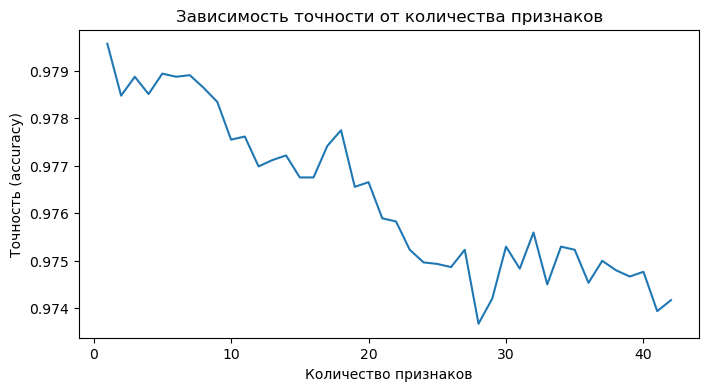

In [59]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel("Количество признаков")
plt.ylabel("Точность (accuracy)")
plt.title("Зависимость точности от количества признаков")
plt.show()

In [60]:
columns_list = selected_features.tolist()
X_train_ = pd.DataFrame(X_train, columns = columns_list)
X_test_ = pd.DataFrame(X_test, columns = columns_list)

In [61]:
# Перемешивание данных
X_train_, y_train_ = shuffle(X_train_, y_train, random_state=42)

In [62]:
# Обучение модели
model = RandomForestClassifier(n_jobs = -1)#  DecisionTreeClassifier() #XGBClassifier() #KNeighborsClassifier() #
model.fit(X_train_, y_train_)

# Получение предсказаний на тестовых данных
y_pred = model.predict(X_test_)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Точность:", accuracy)
print("Отчет по классификации:\n", report)

Точность: 0.645212554628526
Отчет по классификации:
               precision    recall  f1-score   support

           0       0.46      0.20      0.28      2592
           1       0.68      0.88      0.76      4959

    accuracy                           0.65      7551
   macro avg       0.57      0.54      0.52      7551
weighted avg       0.60      0.65      0.60      7551



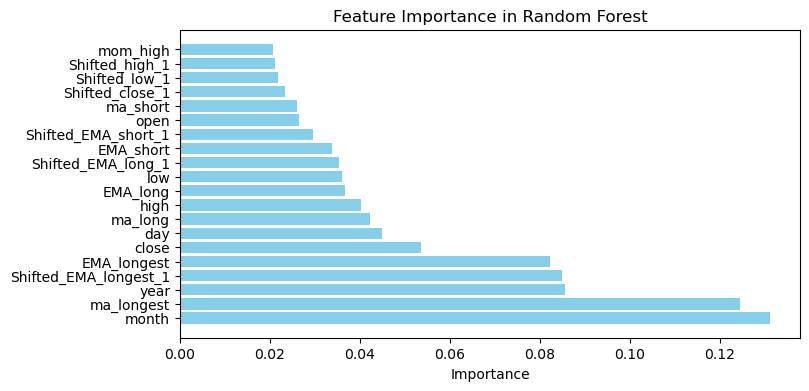

In [63]:
# Получаем важность признаков
importances = model.feature_importances_

# Создаем DataFrame для удобства визуализации
#feature_names = data.feature_names
importance_df = pd.DataFrame({'Feature': X_train_.columns, 'Importance': importances})

# Сортируем по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализируем важность признаков
plt.figure(figsize=(8, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()

### 4.2. Построение модели с оптимизацией гиперпараметров.

##### Это список параметров, по которым будем искать оптимальные гиперпараметры:

In [66]:
params = {
    'RSI__h_bound': [70],
    'RSI__period': [13, 21],
    'SMA__ma_long': [21, 34],
    'SMA__ma_longest': [200],
    'SMA__ma_short': [5, 8, 13],
    'EMA__ema_long': [21, 34],
    'EMA__ema_longest': [134, 200],
    'EMA__ema_short': [5, 13],
    'RSIEMA__h_bound': [70, 80],
    'RSIEMA__period': [8, 13, 21],
    'ROC__roc_high': [14, 21],
    'ROC__roc_low': [5, 9],
    'MOM__mom_high': [14, 21],
    'MOM__mom_low':  [5, 14],
    'STOCH__stoch_d': [3, 5],
    'STOCH__stoch_k': [5, 8, 13],
    'STOCH__stoch_period': [3, 5],
    'SHIFT1__num_shifts': [3, 5, 8],
    'SHIFT2__num_shifts':[1, 3],
    'CORRELATION_REMOVER__threshold': [0.03, 0.01],
    'DEPENDENCIES_REMOVER__correlation_threshold': [0.8, 0.5, 0.3],
    'DATAPREPROCESSOR__apply_balancing': [False],
    'DATAPREPROCESSOR__apply_scaling': [True, False]
    }

In [67]:
2**15*3**5 # число комбинаций

7962624

#### Ниже демонстрация работы скрипта при поиске оптимальынх гиперпараметров. Результаты длительного поиска гиперпараметров есть в отдельном файле.

Номер комбинации: 1 Текущая комбинация: {'RSI__h_bound': 70, 'RSI__period': 21, 'SMA__ma_long': 21, 'SMA__ma_longest': 200, 'SMA__ma_short': 5, 'EMA__ema_long': 21, 'EMA__ema_longest': 200, 'EMA__ema_short': 13, 'RSIEMA__h_bound': 80, 'RSIEMA__period': 21, 'ROC__roc_high': 14, 'ROC__roc_low': 5, 'MOM__mom_high': 14, 'MOM__mom_low': 5, 'STOCH__stoch_d': 3, 'STOCH__stoch_k': 5, 'STOCH__stoch_period': 5, 'SHIFT1__num_shifts': 8, 'SHIFT2__num_shifts': 1, 'CORRELATION_REMOVER__threshold': 0.03, 'DEPENDENCIES_REMOVER__correlation_threshold': 0.8, 'DATAPREPROCESSOR__apply_balancing': False, 'DATAPREPROCESSOR__apply_scaling': True}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}


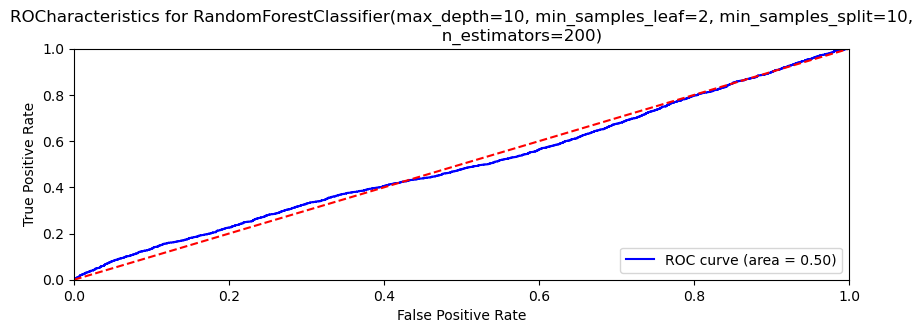

Точность при наилучших параметрах: 0.635280095351609
Номер комбинации: 2 Текущая комбинация: {'RSI__h_bound': 70, 'RSI__period': 21, 'SMA__ma_long': 34, 'SMA__ma_longest': 200, 'SMA__ma_short': 13, 'EMA__ema_long': 21, 'EMA__ema_longest': 200, 'EMA__ema_short': 5, 'RSIEMA__h_bound': 80, 'RSIEMA__period': 21, 'ROC__roc_high': 21, 'ROC__roc_low': 9, 'MOM__mom_high': 21, 'MOM__mom_low': 14, 'STOCH__stoch_d': 3, 'STOCH__stoch_k': 13, 'STOCH__stoch_period': 3, 'SHIFT1__num_shifts': 5, 'SHIFT2__num_shifts': 1, 'CORRELATION_REMOVER__threshold': 0.03, 'DEPENDENCIES_REMOVER__correlation_threshold': 0.3, 'DATAPREPROCESSOR__apply_balancing': False, 'DATAPREPROCESSOR__apply_scaling': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}


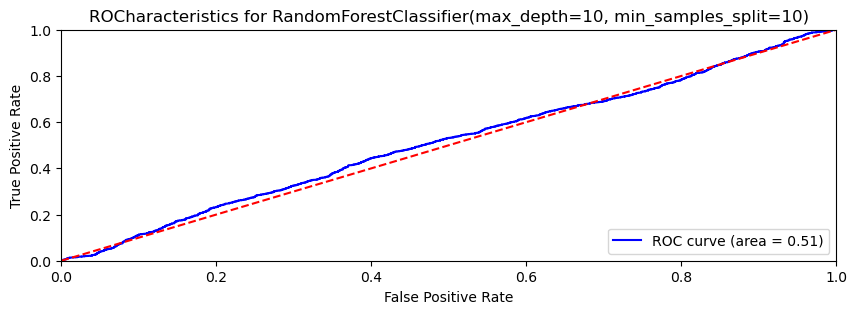

Точность при наилучших параметрах: 0.5563501522977089
Номер комбинации: 3 Текущая комбинация: {'RSI__h_bound': 70, 'RSI__period': 13, 'SMA__ma_long': 21, 'SMA__ma_longest': 200, 'SMA__ma_short': 5, 'EMA__ema_long': 34, 'EMA__ema_longest': 134, 'EMA__ema_short': 5, 'RSIEMA__h_bound': 80, 'RSIEMA__period': 8, 'ROC__roc_high': 14, 'ROC__roc_low': 5, 'MOM__mom_high': 21, 'MOM__mom_low': 5, 'STOCH__stoch_d': 5, 'STOCH__stoch_k': 8, 'STOCH__stoch_period': 5, 'SHIFT1__num_shifts': 5, 'SHIFT2__num_shifts': 1, 'CORRELATION_REMOVER__threshold': 0.03, 'DEPENDENCIES_REMOVER__correlation_threshold': 0.8, 'DATAPREPROCESSOR__apply_balancing': False, 'DATAPREPROCESSOR__apply_scaling': True}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие параметры: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}


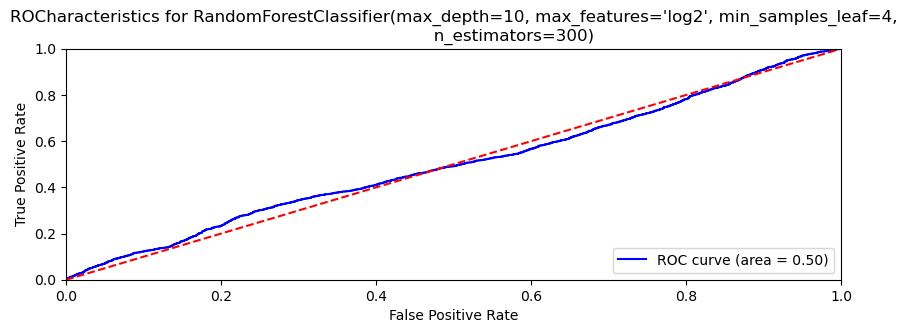

Точность при наилучших параметрах: 0.6289233214143822
Номер комбинации: 4 Текущая комбинация: {'RSI__h_bound': 70, 'RSI__period': 21, 'SMA__ma_long': 21, 'SMA__ma_longest': 200, 'SMA__ma_short': 13, 'EMA__ema_long': 34, 'EMA__ema_longest': 200, 'EMA__ema_short': 13, 'RSIEMA__h_bound': 80, 'RSIEMA__period': 21, 'ROC__roc_high': 21, 'ROC__roc_low': 5, 'MOM__mom_high': 14, 'MOM__mom_low': 14, 'STOCH__stoch_d': 5, 'STOCH__stoch_k': 13, 'STOCH__stoch_period': 5, 'SHIFT1__num_shifts': 3, 'SHIFT2__num_shifts': 1, 'CORRELATION_REMOVER__threshold': 0.01, 'DEPENDENCIES_REMOVER__correlation_threshold': 0.3, 'DATAPREPROCESSOR__apply_balancing': False, 'DATAPREPROCESSOR__apply_scaling': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}


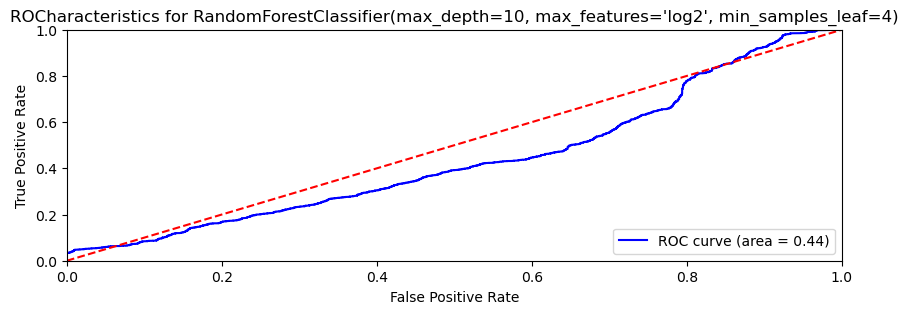

Точность при наилучших параметрах: 0.4545093365117203
Номер комбинации: 5 Текущая комбинация: {'RSI__h_bound': 70, 'RSI__period': 21, 'SMA__ma_long': 21, 'SMA__ma_longest': 200, 'SMA__ma_short': 8, 'EMA__ema_long': 21, 'EMA__ema_longest': 134, 'EMA__ema_short': 13, 'RSIEMA__h_bound': 70, 'RSIEMA__period': 8, 'ROC__roc_high': 21, 'ROC__roc_low': 5, 'MOM__mom_high': 21, 'MOM__mom_low': 14, 'STOCH__stoch_d': 5, 'STOCH__stoch_k': 5, 'STOCH__stoch_period': 3, 'SHIFT1__num_shifts': 8, 'SHIFT2__num_shifts': 1, 'CORRELATION_REMOVER__threshold': 0.03, 'DEPENDENCIES_REMOVER__correlation_threshold': 0.3, 'DATAPREPROCESSOR__apply_balancing': False, 'DATAPREPROCESSOR__apply_scaling': True}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}


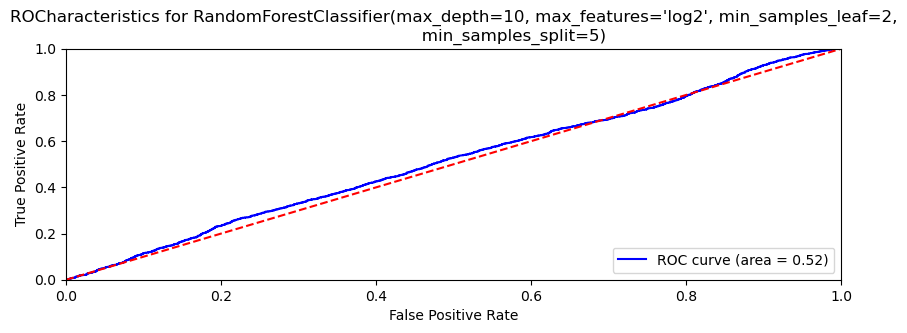

Точность при наилучших параметрах: 0.5579393457820156
Номер комбинации: 6 Текущая комбинация: {'RSI__h_bound': 70, 'RSI__period': 21, 'SMA__ma_long': 34, 'SMA__ma_longest': 200, 'SMA__ma_short': 13, 'EMA__ema_long': 34, 'EMA__ema_longest': 200, 'EMA__ema_short': 5, 'RSIEMA__h_bound': 70, 'RSIEMA__period': 21, 'ROC__roc_high': 14, 'ROC__roc_low': 5, 'MOM__mom_high': 21, 'MOM__mom_low': 5, 'STOCH__stoch_d': 5, 'STOCH__stoch_k': 5, 'STOCH__stoch_period': 3, 'SHIFT1__num_shifts': 5, 'SHIFT2__num_shifts': 3, 'CORRELATION_REMOVER__threshold': 0.01, 'DEPENDENCIES_REMOVER__correlation_threshold': 0.3, 'DATAPREPROCESSOR__apply_balancing': False, 'DATAPREPROCESSOR__apply_scaling': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}


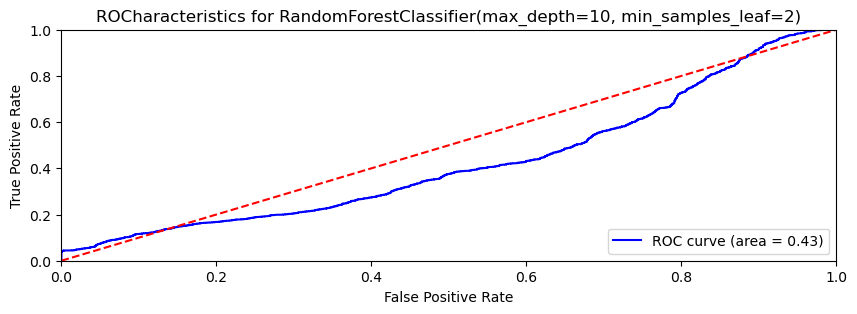

Точность при наилучших параметрах: 0.44987418884915903
Номер комбинации: 7 Текущая комбинация: {'RSI__h_bound': 70, 'RSI__period': 21, 'SMA__ma_long': 34, 'SMA__ma_longest': 200, 'SMA__ma_short': 8, 'EMA__ema_long': 21, 'EMA__ema_longest': 200, 'EMA__ema_short': 13, 'RSIEMA__h_bound': 80, 'RSIEMA__period': 21, 'ROC__roc_high': 21, 'ROC__roc_low': 5, 'MOM__mom_high': 21, 'MOM__mom_low': 14, 'STOCH__stoch_d': 5, 'STOCH__stoch_k': 8, 'STOCH__stoch_period': 5, 'SHIFT1__num_shifts': 3, 'SHIFT2__num_shifts': 1, 'CORRELATION_REMOVER__threshold': 0.01, 'DEPENDENCIES_REMOVER__correlation_threshold': 0.8, 'DATAPREPROCESSOR__apply_balancing': False, 'DATAPREPROCESSOR__apply_scaling': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}


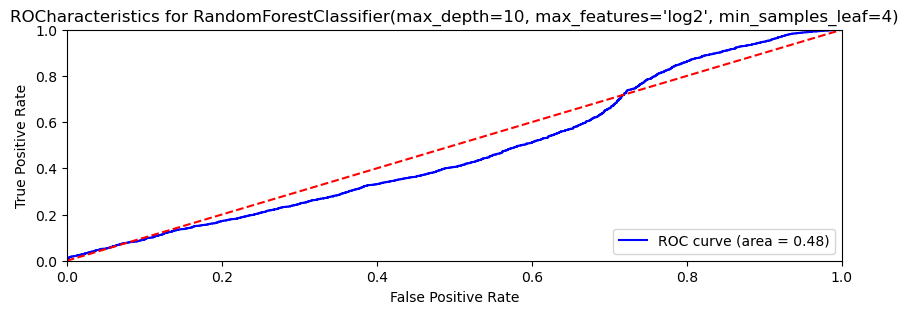

Точность при наилучших параметрах: 0.6287908886240233
Номер комбинации: 8 Текущая комбинация: {'RSI__h_bound': 70, 'RSI__period': 13, 'SMA__ma_long': 34, 'SMA__ma_longest': 200, 'SMA__ma_short': 5, 'EMA__ema_long': 34, 'EMA__ema_longest': 200, 'EMA__ema_short': 13, 'RSIEMA__h_bound': 70, 'RSIEMA__period': 8, 'ROC__roc_high': 14, 'ROC__roc_low': 9, 'MOM__mom_high': 21, 'MOM__mom_low': 14, 'STOCH__stoch_d': 5, 'STOCH__stoch_k': 8, 'STOCH__stoch_period': 5, 'SHIFT1__num_shifts': 3, 'SHIFT2__num_shifts': 3, 'CORRELATION_REMOVER__threshold': 0.03, 'DEPENDENCIES_REMOVER__correlation_threshold': 0.5, 'DATAPREPROCESSOR__apply_balancing': False, 'DATAPREPROCESSOR__apply_scaling': True}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}


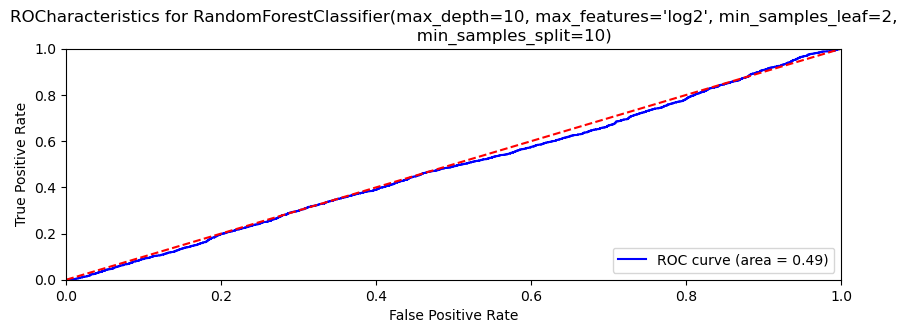

Точность при наилучших параметрах: 0.5942259303403523
Достигнут лимит комбинаций или все комбинации исчерпаны


In [68]:
result = pd.DataFrame()
# Переберем percent_to_process всех возможных комбинаций
combinator = UniqueParameterCombinator(params, percent_to_process=0.0001)

i = 0

# Получаем уникальные комбинации
while True:
    custom_pipeline = CustomPipeline()
    pipeline_transform = custom_pipeline.get_pipeline()
    
    combination = combinator.get_next_unique_combination()
    if combination is None:
        print("Достигнут лимит комбинаций или все комбинации исчерпаны")
        break
    
    df_full = df_use.copy()
    
    i += 1
    print("Номер комбинации:", i, "Текущая комбинация:", combination)   
    
    # Установка параметров в pipeline
    try:
        pipeline_transform.set_params(**combination)
        
        # Применение трансформации к полному набору данных
        #data_for_analysis = 
        pipeline_transform.fit(df_full)
        #X_full, y_full = data_for_analysis.transform(df_full)
        X_full, y_full = pipeline_transform.transform(df_full)
        
        # Разделение данных на обучающую и тестовую выборки
        X_train = X_full.iloc[:train_size]
        X_test = X_full.iloc[train_size:]
        y_train = y_full.iloc[:train_size]
        y_test = y_full.iloc[train_size:]
        
        rf = RandomForestClassifier()
        
        # Определяем параметры для поиска
        param_dist = {
            'n_estimators': [100, 200, 300],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

        # Инициализация RandomizedSearchCV
        rf_random = RandomizedSearchCV(estimator=rf,
                                        param_distributions=param_dist,
                                        n_iter=100,
                                        cv=3,
                                        verbose=2,
                                        random_state=42,
                                        n_jobs=-1)
        
        # Обучение модели
        rf_random.fit(X_train, y_train)
        
        # Получение лучших параметров и модели
        best_params = rf_random.best_params_
        best_model = rf_random.best_estimator_
        
        print("Лучшие параметры:", best_params)
        evaluator = ModelEvaluator(best_model)
        evaluator.fit(X_train, y_train)  # Обучаем модель
        results_df, tpr_fpr_df = evaluator.evaluate(X_test, y_test)  # Оцениваем модель
        
        result_prel = pd.concat([
                                    results_df, 
                                    pd.DataFrame([i, i], columns = ['номер комбинации']), 
                                    pd.DataFrame([combination, combination]), 
                                    pd.DataFrame([best_params, best_params])
                                ],
                                axis = 1)
        result = pd.concat([result, result_prel], axis = 0)
        
        # Оценка точности на тестовом наборе данных
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print("Точность при наилучших параметрах:", accuracy)
        
    except Exception as e:
        print(f"Ошибка при обработке комбинации {combination}: {e}")

    

In [69]:
end_time = time.time()

# Вычисляем время выполнения
execution_time = (end_time - start_time)/60

print(f"Время выполнения скрипта: {execution_time:.2f} минут")

Время выполнения скрипта: 42.39 минут


#### Результаты:  
1. При целях +/- 5% наилучшие результаты: Accuracy = 0.63, ROC_AUC = 0.59 
2. При целях +/- 3% наилучшие результаты: Accuracy = 0.62, ROC_AUC = 0.62  
Ссылка на файл с результатами поиска оптимальных гиперпараметров:
[results.csv](https://drive.google.com/file/d/1xJNaUKxOVmlva_FkN1JbzCS6DsdVmRBw/view?usp=sharing)  
Ссылка на Power BI dashboard с возможностью посмотреть влияния параметров на точность:
[Parameters_impact](https://app.powerbi.com/groups/me/reports/b970c868-1c44-4938-9fac-6fac52dabccb/6d51e5b0440ac16a2d61?experience=power-bi)

### 5. Выводы и рекомендации.

### Выводы:
* В целом, предложенная модель с использованием торговых индикаторов имеет право на существование, выглядит лучше чем простое гадание и может принести доход при торговле на бирже при условии ставки на рост акций, где метод показал более высокую точность.
* Результаты вселяют уверенность, что при дальнейшем улучшении модели можно получить более высокую точность и более высокий доход.

##### Например:
1. Медианой по времени достижения границ в 5% являлись 265 часов, что составляет 365*24/265 = 33 таких периодов.
2. Учитывая, что примерно 57% от всех периодов составляли достижение верхней границы, это примерно 19 периодов.
3. Точность предсказаний даже по всем сделкам около 63% (по ставке на рост выше) или 19 * 63% ~ 12 сделок будем получать прибыль в 5% или 60%.
4. Минус 7 сделок с убытком 5%, что составляет 35%.
5. Накладные расходы (оплата услуг брокера и биржи) примерно не более 1.5% на 33 сделках.
6. Итого: 60% - 35% - 1.5% = 23.5% годовых, что немного выше ставок банковских депозитов.

### Рекомендации:  
1. Дополнить модель другими важными торговыми индикаторами такими как Полосы Bollinger, MACD.
2. Добавить некоторые значимые торговые индикаторы при расчёте на дневном таймфрейме, который лучше отражает долгосрочный тренд, что должно увеличить точность модели.
3. Попробовать использовать для поиска оптимальных гиперпараметров Байесовскую оптимизацию.
4. Протестировать использование нейронных сетей.
5. Использование более мощных платных облачных вычислительных возможностей типа Google Colab или других.